# SIXT33N Phase 2: Controls | Part 1: Open-Loop Control
## EE 16B: Designing Information Devices and Systems II, Spring 2019


**Name 1**:

**Login**: ee16b-


**Name 2**:

**Login**: ee16b-

-----

# Table of Contents

* [Part 0: Powering Your MSP On the Go](#part0)
* [Part 1.0: Intro to Open-Loop Control](#part1.0)
* [Part 1.1: Open-Loop Controller Design](#part1.1)
* [Part 1.2: Open-Loop Simulation](#part1.2)
* [Part 1.3: Jolt Calculation](#part1.3)
* [Part 1.4: Implementation and Checkoff](#part1.4)

-----

<a id='part0'></a>
# <span style="color:blue">Part 0: Powering the MSP</span>

Powering the MSP by both the 5V from the voltage regulator and the USB can increase the odds of MSP frying. To avoid this, you're going to connect the 5V ouput of the voltage regulator to the 5V pin of the MSP via a 22 ohm resistor. This schematic is illustrated below: 
<img style="width:700px" src="images/VoltageRegulatorCircuit.png">
Despite this modification, always avoid simulataneously powering the MSP by the above circuit and the USB. Only use one source at a time. 

-----

<a id='part1.0'></a>
# <span style="color:blue">Part 1: Open Loop Control</span>

## 1.0 Introduction


### <a href="https://drive.google.com/file/d/1LTFDFRN8_X0wspUhJYu4yWnY81fdnR3M/view?usp=sharing">Read the Introduction of the note to familiarize yourself with/remind yourself of the open-loop model.</a>
Last time you modeled the open-loop system, collected data, and determined the unknown parameters of your car.

This week, you'll implement the open-loop and closed-loop systems. By the end of the phase, you should be able to control the trajectory of the car. We will return to turning later in the project. **Remember to document all design choices you made and explain them in the project report.**

The goals of this phase are as follows:
- Controller design
- Closed loop simulation
- Move at constant speed + direction

### <span style="color:red">**Fill in your model parameters and target velocty from System ID below.**</span>

In [8]:
theta_left = 0.3359
theta_right = 0.2948
beta_left = -16.68
beta_right = -12.25
v_star = 54.8

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
params = np.array([(theta_left, theta_right), (beta_left, beta_right)])
d0 = (0,  0)
N = 10 # sim length
mismatch_error = 0.1 # 10% model mismatch

In [11]:
# Functions for simulations and plotting

def sim(params, left, right, eps, offset=0):
    d = np.zeros((N, 2))
    d[0] = d0
    # Deterministically mismatch model parameters so students are guaranteed to see effects
    th, b = np.array(params)*(1+eps*np.array([(1, -1), (1, -1)]))
    for t in range(N-1):
        delta = d[t, 0] - d[t, 1] + offset
        if t < 1: # "Jolt" wheels with maximum power to start
            u = (255, 255)
        else: # Compute input
            try:
                u = (left(v_star, delta), right(v_star, delta))
            except TypeError:
                u = (left(v_star), right(v_star))
        # Saturate inputs
        u = np.minimum(np.maximum(0, np.array(u)), 255)
        # Run single step of system
        d[t+1] = d[t] + th*u - b # The phsyical system
    delta = d[:, 0] - d[:, 1]
    # Post-process delta to determine stability
    ss_error = delta[-1]
    if abs(ss_error - delta[-2]) > 1:
        if abs(ss_error - delta[-3]) < 1e-1:
            ss_error = 'oscillatory'
        else:
            ss_error = "unbounded"
    elif abs(ss_error) < 1:
        ss_error = 0
    try:
        print("Steady state error = {:.2f}".format(ss_error))
    except ValueError:
        print("Steady state error = {}".format(ss_error))
    plt.plot(range(N), d[:, 0], 'b-', range(N), d[:, 1], 'y-')
    plt.xlabel("k (sample)")
    plt.ylabel("Distance")
    plt.legend(("left", "right"), loc="best")
    return delta

def two_sims(left, right, titles):
    plt.figure(figsize=(10, 7))
    plt.subplot(221)
    delta1 = sim(params, left, right, 0)
    plt.title(titles[0])
    plt.subplot(223)
    plt.plot(delta1, 'r')
    plt.ylabel('delta')
    plt.subplot(222)
    delta2 = sim(params, left, right, mismatch_error)
    plt.title(titles[1])
    plt.subplot(224)
    plt.plot(delta2, 'r')
    plt.ylabel('delta')
    return delta1, delta2

<a id='part1.1'></a>
## 1.1 Open Loop Controller Design

### <a href="https://drive.google.com/file/d/1LTFDFRN8_X0wspUhJYu4yWnY81fdnR3M/view?usp=sharing">Read Part 1 of the note before you proceed. Boxed questions make good checkoff questions ;)</a>

Now design an open loop controller that uses the desired wheel velocity, `v_star`, to set the input `u` to an appropriate value for the pulse width modulation (PWM). To do this, solve your model from the previous part for the input $u[k]$ that makes the model velocity $d[k+1] - d[k]$ equal to the desired velocity $v^*$.

In [12]:
# DESIGN YOUR OPEN-LOOP CONTROL HERE
def driveStraight_left_OL(v_star):
    
    # YOUR CODE HERE
    return (v_star + beta_left)/theta_left
def driveStraight_right_OL(v_star):
    # YOUR CODE HERE
    return (v_star + beta_right)/theta_right

<a id='part1.2'></a>
## 1.2 Open Loop Simulation

### <a href="https://drive.google.com/file/d/1LTFDFRN8_X0wspUhJYu4yWnY81fdnR3M/view?usp=sharing">If you haven't yet, read Part 2 of the note.</a>

Now, let's do a quick simulation to check the behavior of the car based on our functions above. In these simulations, we apply maximum PWM for a short time as we do in the real car to "jolt" the motors from a stop.

**Important:** As long as $\delta$ is constant, even if $\delta\neq 0$, the car still travels straight! Traveling straight means the *velocities*, not the positions, of the wheels are the same. It may just travel straight in a different direction than the original heading. Lets call the steady state (final) value $\delta_{ss}$.

In the left two plots, we assume the physical system perfectly matches our model. On the right, we assume the physical system is 10% different from our model.

Steady state error = 14.91
Steady state error = unbounded


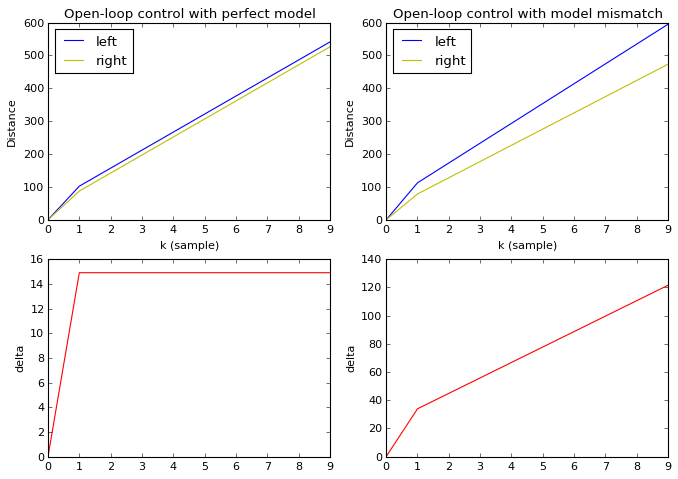

In [13]:
titles = ["Open-loop control with perfect model",
          "Open-loop control with model mismatch"]
_,_ = two_sims(driveStraight_left_OL, driveStraight_right_OL, titles)

From the above plots, we can see that the open-loop car travels straight only with a perfect model.

<a id='part1.3'></a>
## 1.3 Jolt Calculation

### <a href="https://drive.google.com/file/d/1LTFDFRN8_X0wspUhJYu4yWnY81fdnR3M/view?usp=sharing">Before you proceed, read Part 3 of the note.</a>

We find the jolts below by calculating the inputs that result in the minimum of the maximum velocities of both wheels. 

- **Make sure your `data_coarse.txt` file from System ID is in the same directory as the iPython notebook.**
- Run the code below to find your initial jolt values.
- Your initial jolt values are correct if they are the input values that correspond to the points where the blue and yellow lines intersect the green line respectively.

int left_jolt = 155;
int right_jolt = 190;


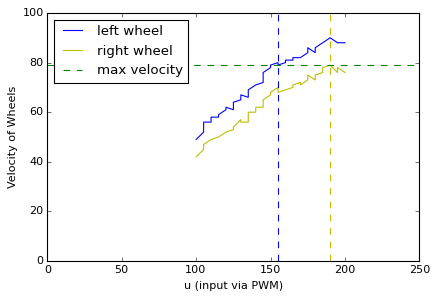

In [14]:
def find_closest_idx(arr, val):
    """
    Given an array of velocities and a value, returns the index of the array where arr[index] is the closest to the given value
    """
    return np.array(abs(arr-val)).argmin()

def find_jolt(): 
    with open('data_coarse.txt', 'r') as file:
        data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])

    # compute velocity from distances
    vleft  = data[:, 1]
    vright = data[:, 2]
    u = data[:, 0].reshape((-1, 1)) # duty cycle

    left_des, _ = np.array_split(vleft, 2)
    right_des, _ = np.array_split(vright, 2)
    u_des, _ = np.array_split(u, 2)
    
    plt.figure()
    plt.axis((0, 250, 0, max(max(left_des), max(right_des))+10))
    max_vel = min(max(left_des), max(right_des))
    plt.plot(u_des, left_des, 'b',  u_des, right_des, 'y')
    plt.axhline(max_vel, color='g', linestyle='--')
    plt.xlabel("u (input via PWM)")
    plt.ylabel("Velocity of Wheels")
    labels = ("left wheel" , "right wheel", "max velocity")
    plt.legend(labels, loc=2)
    
    left_idx = find_closest_idx(left_des, max_vel)
    right_idx = find_closest_idx(right_des, max_vel)
    left_jolt = u_des[left_idx][0]
    right_jolt = u_des[right_idx][0]
    plt.axvline(left_jolt, color='b', linestyle='--')
    plt.axvline(right_jolt, color='y', linestyle='--')
    return left_jolt, right_jolt

left_jolt, right_jolt = find_jolt()
print('int left_jolt = {};\nint right_jolt = {};'.format(left_jolt, right_jolt))

<a id='part1.4'></a>
## 1.4 Open Loop Implementation

Now implement the controller on the Launchpad. The sketch **`open_loop.ino`** contains some code that implements the open loop control.

- Fill in these values in `CODE BLOCK CON1`:
    - desired velocity: `v_star` 
    - estimated parameters: `theta_left`, `theta_right`, `beta_left`, `beta_right`
    - initial jolt values: `left_jolt`, `right_jolt`
    
    
- Additionally, we need to compute the PWM input to the motors in `CODE BLOCK CON2`:
    - Complete `driveStraght_left_OL()` and `driveStraight_right_OL()` to compute `left_cur_pwm` and `right_cur_pwm` (the PWM inputs for each wheel required for a desired v_star)
    
    
- Fill out `CODE BLOCK CON0` to calculate the control inputs using the functions from `CODE BLOCK CON2`.
- Upload the sketch to your Launchpad.
- **Make sure that the car is suspended above the desk.** Your car wheels are going to move in this step.

Once you are satisfied that your motors work and your open loop control is implemented, put the car on the ground. Make sure the motor switch is on (and that both your motors are still plugged in) and press the `RST` button on your Launchpad. SIXT33N should move straighter than previously because you have accounted for differences in the two motors. Does it behave how you expect? It's okay if it doesn't drive completely straight at this stage.

-----

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">
<br/>
# <span style="color:green">CHECKOFF</span>
<span style="color:green">**Show your GSI the functioning open-loop control.**</span>
## <span style="color:red">**REMEMBER TO SAVE ALL YOUR DATA!!**</span>